In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import copy

!pip install torchmetrics
import torchmetrics

!pip install einops
import einops



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00


In [2]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=59a2af299a9d4fe531023abec948ae87f6820dac5a9b31273fcfdb902f86e714
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=64ec522eb72b470a6d995997f019797bcd8052336d357f21fcbebcfba100545a
  Stored in directory: /root/.cache/pip/w

In [7]:
!pip install unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!gdown https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
!mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
#https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
!unzip Dataset_Student_annot.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Student/val/data/video_1941/image_11.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_11.png  
  inflating: Dataset_Student/val/data/video_1941/image_8.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_8.png  
  inflating: Dataset_Student/val/data/video_1941/image_9.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_9.png  
  inflating: Dataset_Student/val/data/video_1941/mask.npy  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._mask.npy  
  inflating: Dataset_Student/val/data/video_1941/image_2.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_2.png  
  inflating: Dataset_Student/val/data/video_1941/image_3.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_3.png  
  inflating: Dataset_Student/val/data/video_1941/image_1.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_1.

In [5]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any


class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.


    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='image_{:d}.png',
                 transform = None,
                 mask: bool =False,
                 mask_template: str='mask.npy',
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.mask = mask
        self.mask_template = mask_template
        self.test_mode = test_mode

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')
    
    def _load_mask(self, directory: str) -> torch.Tensor:
        return torch.Tensor(np.load(os.path.join(directory, self.mask_template)))

    def _parse_annotationfile(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            images = self.transform(images)

        if self.mask:
            mask = self._load_mask(record.path)
            return images, record.label, mask

        return images, record.label

    def __len__(self):
        return len(self.video_list)

class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list: List[Image.Image]) -> 'torch.Tensor[NUM_IMAGES, CHANNELS, HEIGHT, WIDTH]':
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.

        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])

In [54]:
### Dataloader method
def load_data(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            transforms.Resize((160,240)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=True,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

### Load the train and validation datasets
batch_size = 2
trainloader = load_data('Dataset_Student/train/data/', 'Dataset_Student/train/annotations.txt', batch_size)
valloader = load_data('Dataset_Student/val/data/', 'Dataset_Student/val/annotations.txt', batch_size)

In [6]:
#Unet_masker = smp.Unet(
#    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#    encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
#    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#    classes=49,                      # model output channels (number of classes in your dataset)
#)

In [13]:
import unet
Unet_masker = unet.UNet2D(in_channels=3, out_classes=49)

In [64]:
### Code from: https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [78]:
Unet_masker = UNet(                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    n_class=49,                      # model output channels (number of classes in your dataset)
)

In [79]:
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import optim

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
#criterion = smp.losses.JaccardLoss(mode="multiclass")
weight = torch.ones(49)
weight[0] = 0.3
weight = weight.to(device)
steps = num_epochs * len(trainloader)
criterion = CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(Unet_masker.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=steps, eta_min=0.000001)

Epoch 1/5 (Train):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


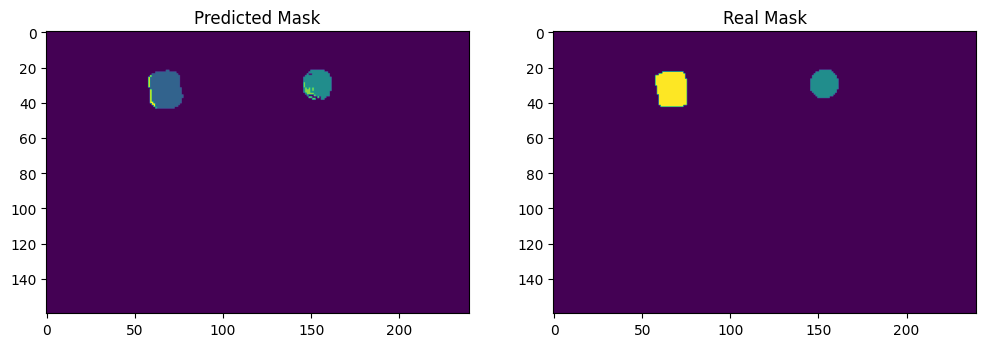

Epoch 2/5 (Train):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


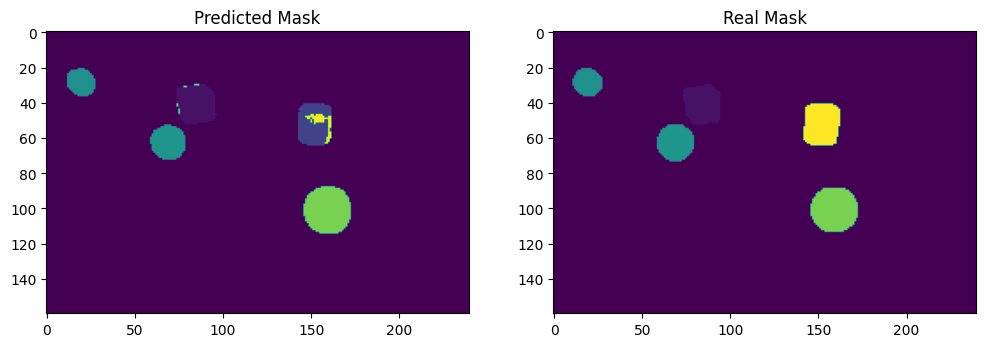

Epoch 3/5 (Train):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


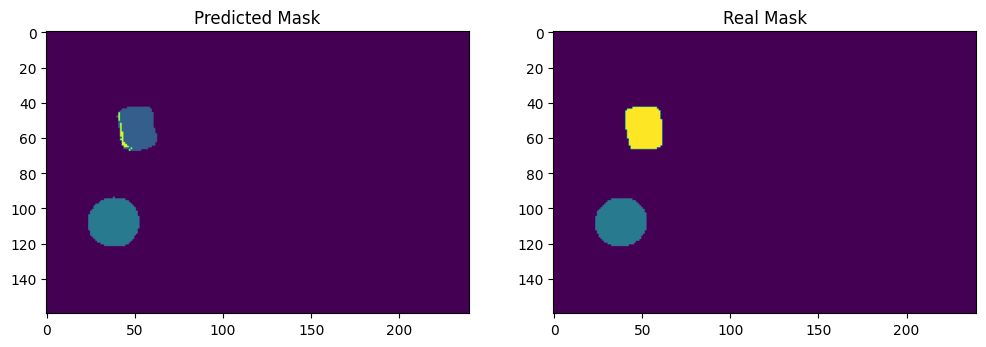

Epoch 4/5 (Train):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


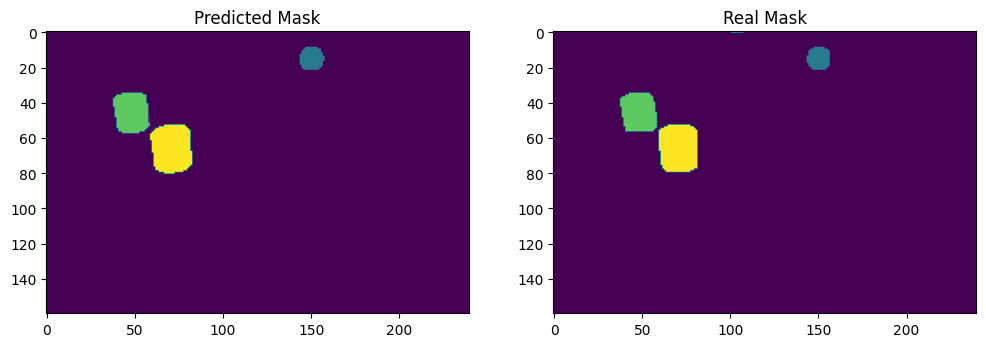

Epoch 5/5 (Train):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

torch.Size([44, 160, 240])
torch.Size([44, 160, 240])


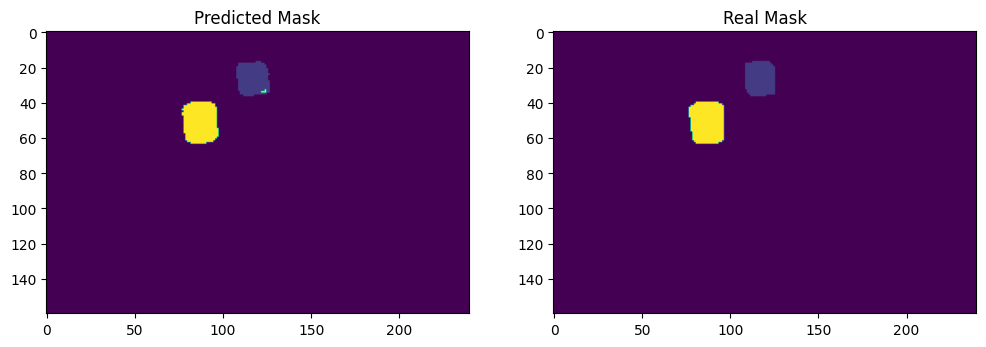

In [80]:
from tqdm import tqdm
from einops import rearrange



Unet_masker.to(device)

def train_model(model, trainloader, valloader, optimizer, criterion, device, epochs):
  # Training loop
  for epoch in range(epochs):
      # Training
      model.train()
      train_loss = 0
      train_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
      for frames, labels, masks in train_tqdm:
          frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

          optimizer.zero_grad()
          frames = rearrange(frames, 'b t c h w -> (b t) c h w')
          masks = rearrange(masks, 'b t h w -> (b t) h w')
          #print(frames.shape)
          outputs = model(frames)
          #print(outputs.shape)
          #print(masks.shape)
          loss = criterion(outputs, masks.long())
          loss.backward()
          optimizer.step()
          scheduler.step()

          train_loss += loss.item()
          train_tqdm.set_postfix({'train_loss': train_loss / (train_tqdm.n + 1), 'learning_rate': optimizer.param_groups[0]['lr']})

      # Validation
      model.eval()
      val_loss = 0
      val_tqdm = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
      with torch.no_grad():
          for frames, labels, masks in val_tqdm:
              frames, labels, masks = frames.to(device), labels.to(device), masks.to(device)

              frames = rearrange(frames, 'b t c h w -> (b t) c h w')
              masks = rearrange(masks, 'b t h w -> (b t) h w')
              outputs = model(frames)
              loss = criterion(outputs, masks.long())

              val_loss += loss.item()
              val_tqdm.set_postfix({'val_loss': val_loss / (val_tqdm.n + 1)})

          # Convert the tensors to numpy arrays for visualization
          outputs = torch.argmax(outputs, dim=1)
          print(outputs.shape)
          print(masks.shape)
          outputs = outputs.cpu().numpy()
          masks = masks.cpu().numpy()
          # Choose the first sample in the batch to visualize
          sample_id = 0

          # Plot the predicted mask and real mask
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
          ax1.imshow(outputs[sample_id])
          ax1.set_title("Predicted Mask")
          ax2.imshow(masks[sample_id])
          ax2.set_title("Real Mask")
          plt.show()


train_model(Unet_masker, trainloader, valloader, optimizer, criterion, device, num_epochs)
